# About Dataset

link https://www.kaggle.com/datasets/nageshsingh/dna-sequence-dataset?utm_source=chatgpt.com&select=human.txt

DNA sequence dataset in text and fasta format of different animals.

## Imports

In [8]:
import kagglehub
import os
import pandas as pd
import numpy as np
import re
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

import tensorflow as tf
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Plots
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (6,4)


## load The Data

In [2]:
# Download latest version
path = kagglehub.dataset_download("nageshsingh/dna-sequence-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'dna-sequence-dataset' dataset.
Path to dataset files: /kaggle/input/dna-sequence-dataset


In [3]:
print(os.listdir(path))

['dog.txt', 'example_dna.fa', 'human.txt', 'chimpanzee.txt']


In [5]:
classes = ['human', 'chimpanzee', 'dog']

def read_file(fname):
    with open(os.path.join(path, fname)) as f:
        seqs = f.read().splitlines()
    seqs = [s.strip().upper() for s in seqs if len(s.strip())>0]
    seqs = [re.sub(r'[^ACGT]', '', s) for s in seqs]   # keep only A/C/G/T
    return pd.DataFrame({'sequence': seqs})

human_df = read_file('human.txt');  human_df['label']='human'
chimp_df = read_file('chimpanzee.txt'); chimp_df['label']='chimpanzee'
dog_df = read_file('dog.txt');      dog_df['label']='dog'

print(len(human_df), len(chimp_df), len(dog_df))

4381 1683 821


In [6]:
df_all = pd.concat([human_df, chimp_df, dog_df]).reset_index(drop=True)
print(df_all['label'].value_counts())


label
human         4381
chimpanzee    1683
dog            821
Name: count, dtype: int64


In [9]:
X = df_all['sequence'].values
y = df_all['label'].astype('category').cat.codes.values
id2label = dict(enumerate(df_all['label'].astype('category').cat.categories))
print(id2label)

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.1111, stratify=y_trainval, random_state=42)

print("Train:", len(X_train), "Val:", len(X_val), "Test:", len(X_test))
print(Counter(y_train))


{0: 'chimpanzee', 1: 'dog', 2: 'human'}
Train: 5507 Val: 689 Test: 689
Counter({np.int8(2): 3504, np.int8(0): 1346, np.int8(1): 657})


In [10]:
def to_kmers(seq, k=4):
    return " ".join(seq[i:i+k] for i in range(len(seq)-k+1))

Xtr_k = [to_kmers(s,4) for s in X_train]
Xv_k  = [to_kmers(s,4) for s in X_val]
Xte_k = [to_kmers(s,4) for s in X_test]

tfidf = TfidfVectorizer(analyzer='word', token_pattern=r'[ACGT]{4}',
                        lowercase=False, min_df=2, sublinear_tf=True)
Xtr_vec = tfidf.fit_transform(Xtr_k)
Xv_vec  = tfidf.transform(Xv_k)
Xte_vec = tfidf.transform(Xte_k)

lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(Xtr_vec, y_train)
pred = lr.predict(Xte_vec)
print("TF-IDF + LogReg — macro F1:", f1_score(y_test, pred, average='macro'))
print(classification_report(y_test, pred, target_names=[id2label[i] for i in range(len(id2label))]))


TF-IDF + LogReg — macro F1: 0.4235932864673835
              precision    recall  f1-score   support

  chimpanzee       0.32      0.35      0.34       169
         dog       0.21      0.61      0.31        82
       human       0.83      0.50      0.62       438

    accuracy                           0.48       689
   macro avg       0.45      0.49      0.42       689
weighted avg       0.63      0.48      0.52       689



In [11]:
vocab = {'A':1, 'C':2, 'G':3, 'T':4}
PAD = 0
MAX_LEN = 300

def encode_pad(seq, max_len=MAX_LEN):
    arr = [vocab.get(ch, PAD) for ch in seq]
    if len(arr) >= max_len:
        return np.array(arr[:max_len], dtype=np.int32)
    out = np.zeros(max_len, dtype=np.int32)
    out[:len(arr)] = arr
    return out

Xtr = np.stack([encode_pad(s) for s in X_train])
Xv  = np.stack([encode_pad(s) for s in X_val])
Xte = np.stack([encode_pad(s) for s in X_test])
print(Xtr.shape, Xv.shape, Xte.shape)


(5507, 300) (689, 300) (689, 300)


it’s just that your dataset itself is noisy / imbalanced or mixed incorrectly.

In [13]:
print("Human examples:\n", human_df['sequence'].head().tolist())
print("\nChimpanzee examples:\n", chimp_df['sequence'].head().tolist())
print("\nDog examples:\n", dog_df['sequence'].head().tolist())


Human examples:
 ['CCA', 'ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCATACTCCTTACACTATTCCTCATCACCCAACTAAAAATATTAAACACAAACTACCACCTACCTCCCTCACCAAAGCCCATAAAAATAAAAAATTATAACAAACCCTGAGAACCAAAATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG', 'ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAGGCCTACCCGCCGCAGTACTGATCATTCTATTTCCCCCTCTATTGATCCCCACCTCCAAATATCTCATCAACAACCGACTAATCACCACCCAACAATGACTAATCAAACTAACCTCAAAACAAATGATAACCATACACAACACTAAAGGACGAACCTGATCTCTTATACTAGTATCCTTAATCATTTTTATTGCCACAACTAACCTCCTCGGACTCCTGCCTCACTCATTTACACCAACCACCCAACTATCTATAAACCTAGCCATGGCCATCCCCTTATGAGCGGGCACAGTGATTATAGGCTTTCGCTCTAAGATTAAAAATGCCCTAGCCCACTTCTTACCACAAGGCACACCTACACCCCTTATCCCCATACTAGTTATTATCGAAACCATCAGCCTACTCATTCAACCAATAGCCCTGGCCGTACGCCTAACCGCTAACATTACTGCAGGCCACCTACTCATGCACCTAATTGGAAGCGCCACCCTAGCAATATCAACCATTAACCTTCCCTCTACACTTATCATCTTCACAATTCTAATTCTACTGACTATCCTAGAAATCGCTGTCGCCTTAATCCAAGCCTACGTTTTCACACTTCTAGTAAGCCTCTACCTGCACGACAACACATAA', 'ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTGTTCAGTGTCTGAGTGCTATGAAGATTGCACAC

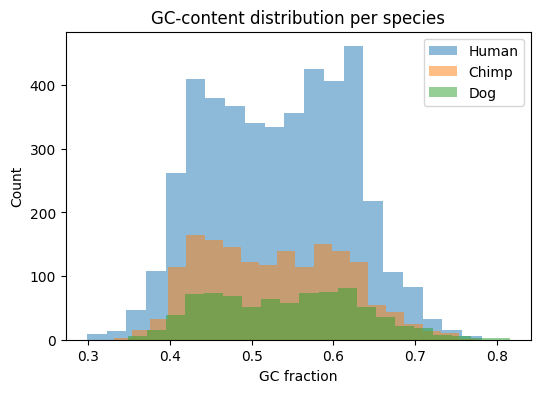

In [14]:
import matplotlib.pyplot as plt

def gc_content(seq):
    g = seq.count('G')
    c = seq.count('C')
    return (g+c)/len(seq) if len(seq)>0 else 0

for species, data in [('Human', human_df), ('Chimp', chimp_df), ('Dog', dog_df)]:
    gc_vals = [gc_content(s) for s in data['sequence']]
    plt.hist(gc_vals, bins=20, alpha=0.5, label=species)

plt.legend(); plt.title("GC-content distribution per species")
plt.xlabel("GC fraction"); plt.ylabel("Count")
plt.show()


In [15]:
from sklearn.metrics import f1_score, classification_report

def pairwise_test(df1, df2, name1, name2):
    df = pd.concat([df1, df2])
    X = df['sequence'].values
    y = df['label'].astype('category').cat.codes.values

    Xtr, Xte, ytr, yte = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    def to_kmers(seq, k=4): return " ".join(seq[i:i+k] for i in range(len(seq)-k+1))
    Xtr_k = [to_kmers(s,4) for s in Xtr]
    Xte_k = [to_kmers(s,4) for s in Xte]

    tfidf = TfidfVectorizer(analyzer='word', token_pattern=r'[ACGT]{4}', lowercase=False, min_df=2)
    Xtr_vec = tfidf.fit_transform(Xtr_k)
    Xte_vec = tfidf.transform(Xte_k)

    lr = LogisticRegression(max_iter=1000, class_weight='balanced')
    lr.fit(Xtr_vec, ytr)
    pred = lr.predict(Xte_vec)

    f1 = f1_score(yte, pred, average='macro')
    print(f"\n{name1} vs {name2} → macro-F1: {f1:.4f}")
    print(classification_report(yte, pred, target_names=[name1, name2]))

pairwise_test(human_df, chimp_df, "Human", "Chimp")
pairwise_test(human_df, dog_df, "Human", "Dog")
pairwise_test(chimp_df, dog_df, "Chimp", "Dog")



Human vs Chimp → macro-F1: 0.6074
              precision    recall  f1-score   support

       Human       0.40      0.74      0.52       337
       Chimp       0.85      0.58      0.69       876

    accuracy                           0.62      1213
   macro avg       0.63      0.66      0.61      1213
weighted avg       0.73      0.62      0.64      1213


Human vs Dog → macro-F1: 0.5665
              precision    recall  f1-score   support

       Human       0.27      0.73      0.39       164
         Dog       0.92      0.62      0.74       877

    accuracy                           0.64      1041
   macro avg       0.59      0.67      0.57      1041
weighted avg       0.82      0.64      0.69      1041


Chimp vs Dog → macro-F1: 0.5624
              precision    recall  f1-score   support

       Chimp       0.73      0.62      0.67       337
         Dog       0.40      0.52      0.46       164

    accuracy                           0.59       501
   macro avg       0.57    